# Representation Jensen-Rényi Divergence Variational Autoencoder
This experiment compares with an Maximum Mean Discrepancy Variational Autoencoder introduced in 

Zhao, S., Song, J., & Ermon, S. (2017). InfoVAE: Information Maximizing Variational Autoencoders. ArXiv, abs/1706.02262.

The code below is based on https://github.com/ShengjiaZhao/MMD-Variational-Autoencoder/blob/master/mmd_vae.ipynb



In [1]:
import torch
from torch.autograd import Variable

from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms

import numpy as np
from matplotlib import pyplot as plt
import math, os
import sys

# TODO: Need to unify this with matrix-itl library
# path_to_itllib = "/home/lgsanchez/work/Code/research/matrix-itl/src/python/"
path_to_itllib = "../matrix-itl/src/python/"
sys.path.insert(1, path_to_itllib)

import kernel_utils_torch as ku
import matrix_itl_torch as itl

In [2]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)

In [3]:
# Encoder and decoder use the DC-GAN architecture
class Encoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Conv2d(1, 64, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            Flatten(),
            torch.nn.Linear(6272, 1024),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, z_dim)
        ])
        
    def forward(self, x):
        #print("Encoder")
        #print(x.size())
        for layer in self.model:
            x = layer(x)
            #print(x.size())
        return x
    
    
class Decoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Linear(z_dim, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 7*7*128),
            torch.nn.ReLU(),
            Reshape((128,7,7,)),
            torch.nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 1, 4, 2, padding=1),
            torch.nn.Sigmoid()
        ])
        
    def forward(self, x):
        #print("Decoder")
        #print(x.size())
        for layer in self.model:
            x = layer(x)
            #print(x.size())
        return x



In [9]:
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x[:,None,:] # (x_size, 1, dim)
    y = y[None, :,:] # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(-1)/float(dim)
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

def matrixJRDivergence(x, y):
    alpha = 1.01
    sigma = np.sqrt(x.shape[1]/2)
    ## create labels array and class Gram
    l = torch.ones(x.shape[0] + y.shape[0], dtype=torch.long, device=torch.device('cuda:0'))
    l[x.shape[0]:] = 0
    L = torch.nn.functional.one_hot(l).type(x.dtype)
    Kl = torch.matmul(L, L.t())
    Hl = itl.matrixAlphaEntropy(Kl, alpha=alpha)
    xy = torch.cat((x,y))
    Kxy = ku.gaussianKernel(xy,xy, sigma)
    Hxy = itl.matrixAlphaEntropy(Kxy, alpha=alpha)
    Hj = itl.matrixAlphaJointEntropy([Kxy, Kl], alpha=alpha)
    return  Hl + Hxy - Hj

In [10]:
class Model(torch.nn.Module):
    def __init__(self, z_dim):
        super(Model, self).__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        
    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed

In [11]:
# Convert a numpy array of shape [batch_size, height, width, 1] into a displayable array 
# of shape [height*sqrt(batch_size, width*sqrt(batch_size))] by tiling the images
def convert_to_display(samples):
    cnt, height, width = int(math.floor(math.sqrt(samples.shape[0]))), samples.shape[1], samples.shape[2]
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height, cnt, cnt, width])
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height*cnt, width*cnt])
    return samples


def trainInfoVAE(
    dataloader,
    divergence_func=compute_mmd,
    tradeoff=1.0,
    z_dim=2,
    n_epochs=10,
    use_cuda=True,
    print_every=100,
    plot_every=500
):
    model = Model(z_dim)
    if use_cuda:
        model = model.cuda()
    #print(model)
    optimizer = torch.optim.Adam(model.parameters())
    i = -1
    for epoch in range(n_epochs):
        for images, labels in dataloader:
            i += 1
            optimizer.zero_grad()
            x = Variable(images, requires_grad=False)
            true_samples = Variable(
                torch.randn(200, z_dim),
                requires_grad=False
            )
            if use_cuda:
                x = x.cuda()
                true_samples = true_samples.cuda()
            z, x_reconstructed = model(x)
            div = divergence_func(true_samples, z)
            nll = (x_reconstructed - x).pow(2).mean()
            loss = nll + tradeoff * div
            loss.backward()
            optimizer.step()
            if i % print_every == 0:
                print("Negative log likelihood is {:.5f}, divergence loss is {:.5f}".format(
                    nll.item(), div.item()))
            if i % plot_every == 0:
                gen_z = Variable(
                    torch.randn(100, z_dim),
                    requires_grad=False
                )
                if use_cuda:
                    gen_z = gen_z.cuda()
                samples = model.decoder(gen_z)
                samples = samples.permute(0,2,3,1).contiguous().cpu().data.numpy()
                plt.imshow(convert_to_display(samples), cmap='Greys_r')
                plt.show()
                
    return model

## Train on MNIST

In [12]:
batch_size=200
mnist_train = torch.utils.data.DataLoader(
    MNIST("./tmp/MNIST", train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True, num_workers=3,
    pin_memory=True
)

Negative log likelihood is 0.22158, divergence loss is 0.01110


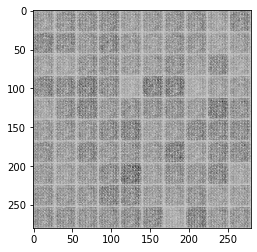

Negative log likelihood is 0.06015, divergence loss is 0.01092
Negative log likelihood is 0.03658, divergence loss is 0.00512
Negative log likelihood is 0.02617, divergence loss is 0.00352
Negative log likelihood is 0.02337, divergence loss is 0.00324
Negative log likelihood is 0.02063, divergence loss is 0.00374


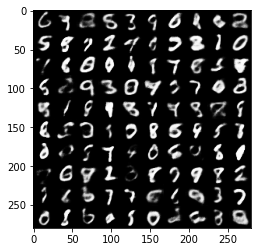

Negative log likelihood is 0.01755, divergence loss is 0.00258
Negative log likelihood is 0.01696, divergence loss is 0.00206
Negative log likelihood is 0.01612, divergence loss is 0.00157
Negative log likelihood is 0.01565, divergence loss is 0.00397
Negative log likelihood is 0.01411, divergence loss is 0.00221


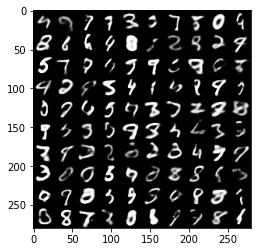

Negative log likelihood is 0.01308, divergence loss is 0.00154
Negative log likelihood is 0.01319, divergence loss is 0.00246
Negative log likelihood is 0.01247, divergence loss is 0.00302
Negative log likelihood is 0.01333, divergence loss is 0.00158
Negative log likelihood is 0.01305, divergence loss is 0.00305


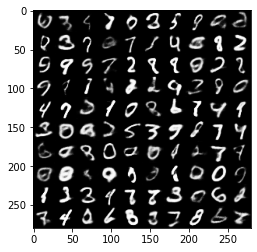

Negative log likelihood is 0.01177, divergence loss is 0.00161
Negative log likelihood is 0.01239, divergence loss is 0.00287
Negative log likelihood is 0.01152, divergence loss is 0.00386
Negative log likelihood is 0.01249, divergence loss is 0.00104
Negative log likelihood is 0.01137, divergence loss is 0.00179


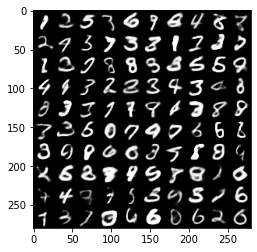

Negative log likelihood is 0.01138, divergence loss is 0.00450
Negative log likelihood is 0.01209, divergence loss is 0.00280
Negative log likelihood is 0.01171, divergence loss is 0.00382
Negative log likelihood is 0.01035, divergence loss is 0.00113
Negative log likelihood is 0.01151, divergence loss is 0.00120


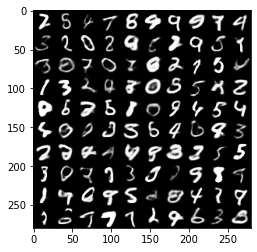

Negative log likelihood is 0.01175, divergence loss is 0.00233
Negative log likelihood is 0.01084, divergence loss is 0.00433
Negative log likelihood is 0.00974, divergence loss is 0.00310
Negative log likelihood is 0.01016, divergence loss is 0.00231
Negative log likelihood is 0.01104, divergence loss is 0.00365


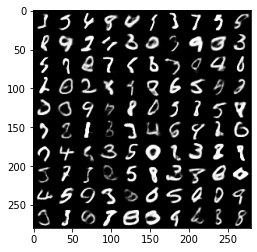

Negative log likelihood is 0.01071, divergence loss is 0.00155
Negative log likelihood is 0.01046, divergence loss is 0.00132
Negative log likelihood is 0.01018, divergence loss is 0.00226
Negative log likelihood is 0.00998, divergence loss is 0.00165
Negative log likelihood is 0.01022, divergence loss is 0.00289


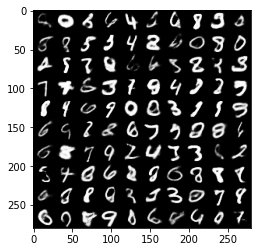

Negative log likelihood is 0.00948, divergence loss is 0.00418
Negative log likelihood is 0.01008, divergence loss is 0.00201
Negative log likelihood is 0.00962, divergence loss is 0.00122
Negative log likelihood is 0.00974, divergence loss is 0.00251
Negative log likelihood is 0.00909, divergence loss is 0.00087


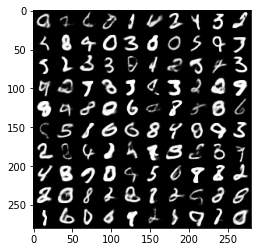

Negative log likelihood is 0.00989, divergence loss is 0.00083
Negative log likelihood is 0.00887, divergence loss is 0.00190
Negative log likelihood is 0.00926, divergence loss is 0.00261
Negative log likelihood is 0.00890, divergence loss is 0.00278
Negative log likelihood is 0.00966, divergence loss is 0.00124


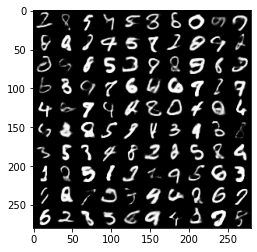

Negative log likelihood is 0.00874, divergence loss is 0.00184
Negative log likelihood is 0.00943, divergence loss is 0.00168
Negative log likelihood is 0.00862, divergence loss is 0.00100
Negative log likelihood is 0.00951, divergence loss is 0.00182
Negative log likelihood is 0.00973, divergence loss is 0.00190


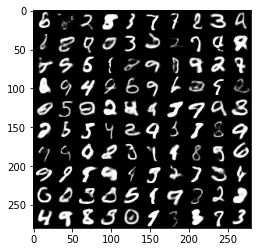

Negative log likelihood is 0.00982, divergence loss is 0.00137
Negative log likelihood is 0.00976, divergence loss is 0.00082
Negative log likelihood is 0.00876, divergence loss is 0.00264
Negative log likelihood is 0.00884, divergence loss is 0.00190
Negative log likelihood is 0.00933, divergence loss is 0.00129


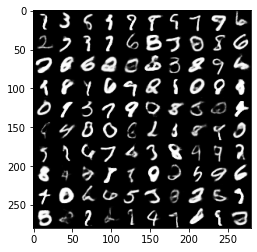

Negative log likelihood is 0.00830, divergence loss is 0.00190
Negative log likelihood is 0.00907, divergence loss is 0.00351
Negative log likelihood is 0.00901, divergence loss is 0.00147
Negative log likelihood is 0.00876, divergence loss is 0.00159


In [13]:
# train MMD Baseline
z_dim = 10
mmd_model = trainInfoVAE(mnist_train, 
                         z_dim=z_dim, 
                         n_epochs=20)



Negative log likelihood is 0.25473, divergence loss is 0.45683


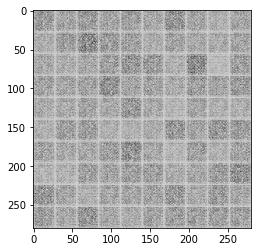

Negative log likelihood is 0.02788, divergence loss is 0.23242
Negative log likelihood is 0.01873, divergence loss is 0.21552
Negative log likelihood is 0.01673, divergence loss is 0.21424
Negative log likelihood is 0.01694, divergence loss is 0.20258
Negative log likelihood is 0.01565, divergence loss is 0.19557


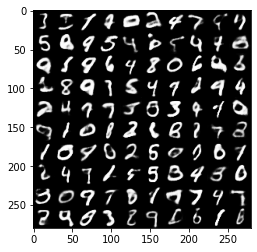

Negative log likelihood is 0.01429, divergence loss is 0.19902
Negative log likelihood is 0.01405, divergence loss is 0.21107
Negative log likelihood is 0.01328, divergence loss is 0.22050
Negative log likelihood is 0.01468, divergence loss is 0.20228
Negative log likelihood is 0.01346, divergence loss is 0.19978


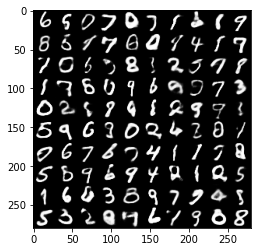

Negative log likelihood is 0.01215, divergence loss is 0.19926
Negative log likelihood is 0.01180, divergence loss is 0.21491
Negative log likelihood is 0.01105, divergence loss is 0.22155
Negative log likelihood is 0.01273, divergence loss is 0.21807
Negative log likelihood is 0.01228, divergence loss is 0.20927


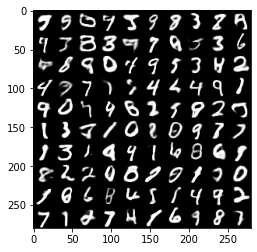

Negative log likelihood is 0.01177, divergence loss is 0.21937
Negative log likelihood is 0.01272, divergence loss is 0.20007
Negative log likelihood is 0.01134, divergence loss is 0.21399
Negative log likelihood is 0.01155, divergence loss is 0.20487
Negative log likelihood is 0.01143, divergence loss is 0.20621


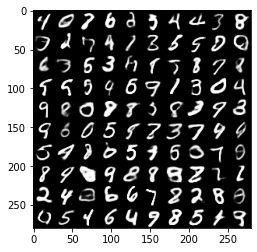

Negative log likelihood is 0.01142, divergence loss is 0.21045
Negative log likelihood is 0.01073, divergence loss is 0.21663
Negative log likelihood is 0.01081, divergence loss is 0.19511
Negative log likelihood is 0.00997, divergence loss is 0.19753
Negative log likelihood is 0.00958, divergence loss is 0.19956


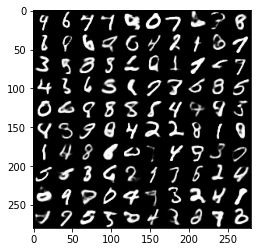

Negative log likelihood is 0.01015, divergence loss is 0.20892
Negative log likelihood is 0.01087, divergence loss is 0.22711
Negative log likelihood is 0.01087, divergence loss is 0.20485
Negative log likelihood is 0.00934, divergence loss is 0.18798
Negative log likelihood is 0.00951, divergence loss is 0.22141


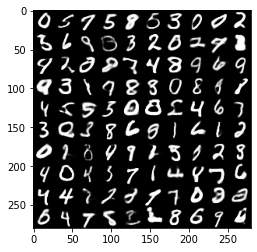

Negative log likelihood is 0.01007, divergence loss is 0.19938
Negative log likelihood is 0.00955, divergence loss is 0.20077
Negative log likelihood is 0.00965, divergence loss is 0.21099
Negative log likelihood is 0.01005, divergence loss is 0.19172
Negative log likelihood is 0.01027, divergence loss is 0.21734


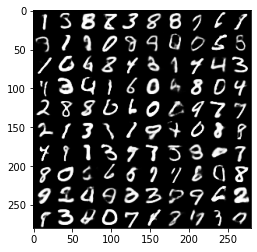

Negative log likelihood is 0.00951, divergence loss is 0.19720
Negative log likelihood is 0.01030, divergence loss is 0.20192
Negative log likelihood is 0.00991, divergence loss is 0.19669
Negative log likelihood is 0.00941, divergence loss is 0.20305
Negative log likelihood is 0.00956, divergence loss is 0.19815


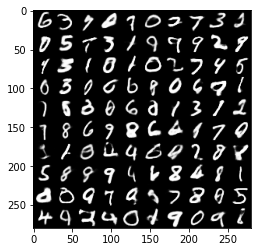

Negative log likelihood is 0.00939, divergence loss is 0.21058
Negative log likelihood is 0.00862, divergence loss is 0.21704
Negative log likelihood is 0.00909, divergence loss is 0.21484
Negative log likelihood is 0.00979, divergence loss is 0.19793
Negative log likelihood is 0.00960, divergence loss is 0.20203


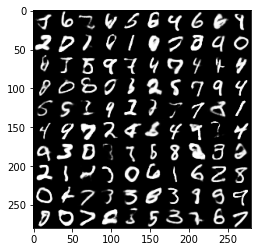

Negative log likelihood is 0.00923, divergence loss is 0.21473
Negative log likelihood is 0.00906, divergence loss is 0.20174
Negative log likelihood is 0.00957, divergence loss is 0.20729
Negative log likelihood is 0.00939, divergence loss is 0.21256
Negative log likelihood is 0.00887, divergence loss is 0.19204


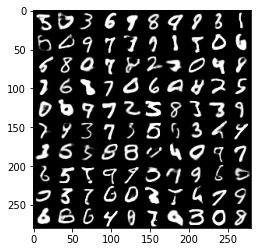

Negative log likelihood is 0.00855, divergence loss is 0.20850
Negative log likelihood is 0.00877, divergence loss is 0.21127
Negative log likelihood is 0.00911, divergence loss is 0.19724
Negative log likelihood is 0.00823, divergence loss is 0.20267
Negative log likelihood is 0.00879, divergence loss is 0.20436


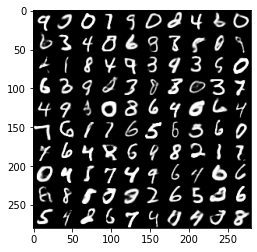

Negative log likelihood is 0.00822, divergence loss is 0.20740
Negative log likelihood is 0.00819, divergence loss is 0.20058
Negative log likelihood is 0.00957, divergence loss is 0.19986
Negative log likelihood is 0.00839, divergence loss is 0.20436


In [14]:
jrd_model = trainInfoVAE(mnist_train, 
                         divergence_func=matrixJRDivergence, 
                         tradeoff=0.1,
                         z_dim=z_dim, 
                         n_epochs=20)

In [15]:
## gather train data to train svm 
def gatherMNISTData(model):
    test_batch_size = 500
    mnist_test = torch.utils.data.DataLoader(
        MNIST("./tmp/MNIST", train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])),
        batch_size=test_batch_size, shuffle=True, num_workers=3,
        pin_memory=True
    )
    z_list, label_list = [], []
    for i in range(100):
        batch_x, batch_y = iter(mnist_test).next()
        batch_x = Variable(batch_x, requires_grad=False).cuda()
        z = model.encoder(batch_x)
        z_list.append(z.cpu().data.numpy())
        label_list.append(batch_y.numpy())
    z_train = np.concatenate(z_list, axis=0)
    label_train = np.concatenate(label_list)

    ## gather test data

    test_batch_size = 500
    mnist_test = torch.utils.data.DataLoader(
        MNIST("./tmp/MNIST", train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])),
        batch_size=test_batch_size, shuffle=True, num_workers=3,
        pin_memory=True
    )
    z_list, label_list = [], []
    for i in range(20):
        batch_x, batch_y = iter(mnist_test).next()
        batch_x = Variable(batch_x, requires_grad=False).cuda()
        z = model.encoder(batch_x)
        z_list.append(z.cpu().data.numpy())
        label_list.append(batch_y.numpy())
    z_test = np.concatenate(z_list, axis=0)
    label_test = np.concatenate(label_list)
    return (z_train, label_train), (z_test, label_test)

In [16]:
mmd_train_data, mmd_test_data = gatherMNISTData(mmd_model)

jrd_train_data, jrd_test_data = gatherMNISTData(jrd_model)


In [20]:
## train an svm classifier
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

def testClassifier(train_data, test_data):
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(train_data[0], train_data[1])

    pred_label = clf.predict(test_data[0])
    acc = np.mean(pred_label == test_data[1])

    print('test accuracy {: 5f}'.format(acc))

In [21]:
testClassifier(mmd_train_data, mmd_test_data)

test accuracy  0.975300


In [22]:
testClassifier(jrd_train_data, jrd_test_data)

test accuracy  0.980800
